# RAC step 2:
1. select data
2. fit data to a Pade approximant
3. analytical continuation to $\lambda = 0$

see *J. Chem. Phys.* **143**, 184102 (2015)

In [1]:
show_plot=True

In [2]:
import sys
import numpy as np
from scipy.optimize import least_squares
import pandas as pd
import matplotlib.pyplot as plt
#%matplotlib qt5
#import matplotlib
#matplotlib.use('Qt5Agg')

library with Pade approximants and their second derivatives 

In [3]:
sys.path.append('../../RAC')
from rac_aux import *
from params import Params
from fitman import bh_with_lsq
au2eV=27.2114

### Select Pade order ([3,1] is recommended.)

In [4]:
nm=32

pade_fns = {"21":(pade_21_lsq, pade_21j_lsq), 
            "31":(pade_31_lsq, pade_31j_lsq), 
            "32":(pade_32_lsq, pade_32j_lsq),
            "41":(pade_41_lsq, pade_41j_lsq),
            "42":(pade_42_lsq, pade_42j_lsq),
            "43":(pade_43_lsq, pade_43j_lsq),
            "52":(pade_52_lsq, pade_52j_lsq),
            "53":(pade_53_lsq, pade_53j_lsq)}

fun=pade_fns[str(nm)][0]
jac=pade_fns[str(nm)][1]

Set data either to `total` or to `relative`. The former is for CCSD(T) total energies for neutral and anion; the latter is for EOM-CCSD attachment data. For the Jolanta potential, all energies are `relative`.

Also, for standard Jolanta-3D, the resonance is the second state. 

In [5]:
#data = 'total'
data = 'relative'
n_state = 'E2'
if data == 'total':
    df = pd.read_csv('CCSDpT_data.csv', delim_whitespace=True)
    df['Eb'] = (df['E1'] - df['E0'])*au2eV
elif data == 'relative':
    #df = pd.read_csv('rac_DVR_b-scale_rmax_12.csv')
    #df = pd.read_csv('rac_DVR_coulomb_rmax_12.csv')
    #df = pd.read_csv('rac_DVR_softbox_rmax_12.csv')
    #df = pd.read_csv('rac_GTO_TZ_0_b-scale.csv')
    df = pd.read_csv('rac_GTO_DZ_0_coulomb.csv')
    #df = pd.read_csv('rac_GTO_TZ_0_softbox.csv')
    df['Eb']=df[n_state]
else:
    print('Data organization not yet implemented:', data)
df.head()

,z,E1,E2,Eb
0,0.000,-7.170439,3.532459,3.532459
1,0.056,-7.754129,3.247214,3.247214
2,0.112,-8.339889,2.964037,2.964037
3,0.168,-8.927554,2.682766,2.682766
4,0.224,-9.516979,2.403256,2.403256


## Data selection
Rule of thumb: use all $E_b < -0.5$ eV

86 bound energies between -0.586212 and -22.315115


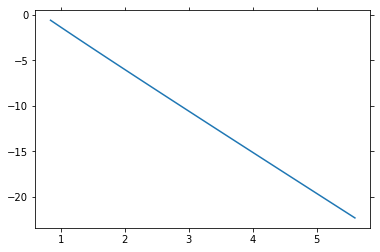

In [6]:
Estart=-0.5
n_first=np.argmin(np.abs(df.Eb.values-Estart))
z0=df['z'][0]
ls=np.copy(df.z.values[n_first:]) - z0
Es=np.copy(df.E2.values[n_first:])
Nval=len(ls)
print('%d bound energies between %f and %f' % (Nval, Es[0], Es[-1]))
if show_plot:
    plt.cla()
    plt.plot(ls,Es)
    plt.show()

Prepare $\kappa^2=-E_b$, $\kappa$, and fitting weights (set to 1) which are all going to be passed to the optimizer.

In [30]:
k2s = -Es
ks  = np.sqrt(k2s)
sigmas = weights(Nval, 'ones')
parg=(ks,k2s,ls,sigmas)

## Fitting procedure
1. Heuristic guess on the basis of linear real extrapolation
2. Fit all selected binding energies to get good guess for $E_r$ 
3. Average over various selection ranges from -0.5 to $n \times E_r$, $n=4-7$

In [31]:
E0 = 0.6*linear_extra(ls,Es)
P0 = Params(E0, ls[0])
p0 = np.array(P0.start(str(nm), adhoc=True, noise=0.05))
print("Start parameters: ", p0)

Start parameters:  [0.82736951 0.2670501  1.35369463 0.83537072 4.86987899]


In [32]:
n_bh=200
sane_bnds = (E0-1, E0+1, 0.01, 1.5)
args = (ks, k2s, ls, sigmas, fun, jac)
best, sane, p0s, df = bh_with_lsq(p0, n_bh, args, sane_bnds, T=1e-4, verbose=1)

  Doing 200 basin hops.
  minimization failures: 15
  11 sane minima found
  Best:  3.133802  0.000000  6.0846e-05
  Sane:  2.819380  0.012558  3.6648e-04


In [33]:
df['Er_rounded']=np.round(df['Er'], decimals=4)
df['G_rounded']=np.round(df['G'], decimals=5)
df.drop_duplicates(subset=["Er_rounded", "G_rounded"])

,chis,Er,G,logs,Er_rounded,G_rounded
60,0.000366,2.819380,0.012558,-3.435945,2.8194,0.01256
191,0.000392,2.800932,0.058897,-3.407103,2.8009,0.05890
109,0.000665,2.624770,0.021789,-3.177499,2.6248,0.02179
112,0.000685,2.623973,0.038878,-3.164138,2.6240,0.03888
197,0.000779,2.629635,0.036992,-3.108708,2.6296,0.03699
99,0.000825,2.558024,0.027262,-3.083357,2.5580,0.02726
93,0.002634,2.705178,0.044181,-2.579439,2.7052,0.04418
67,0.003628,2.707805,0.072292,-2.440379,2.7078,0.07229
82,0.003779,2.727092,0.070691,-2.422588,2.7271,0.07069
78,0.095064,1.911751,0.016875,-1.021983,1.9118,0.01688


Fit `Nval` data points to get a good guess for $E_r$ and provide abundant output to check the optimizer.

In [34]:
print('Least squares, trust-region-reflective (default) with analytic jac')
res = least_squares(fun, p0s, method='trf', jac=jac, args=parg)
print("Jacobi-evaluations, njev:",res.njev)
print("chi**2 = 2*cost:",res.cost)
print("gradient:",res.grad)
print("message:",res.message)
print("success:",res.success)
print("x:", res.x)
print('chi2 = %.3e' % (res.cost*2))
(Er,G) = res_ene(res.x[1], res.x[2])
print("Er=%f,  Gamma=%f" % (Er,G))

Least squares, trust-region-reflective (default) with analytic jac
Jacobi-evaluations, njev: 2
chi**2 = 2*cost: 0.00017308111854457588
gradient: [ 4.94444340e-03 -1.12720377e-04 -3.02227296e-03 -1.54474894e-11
 -7.84924093e-11]
message: `xtol` termination condition is satisfied.
success: True
x: [ 6.63609700e-01 -1.82779333e-02  1.67726459e+00  6.60078256e+06
 -1.29904941e+06]
chi2 = 3.462e-04
Er=2.813216,  Gamma=0.002241


### Energy ranges for averaging procedure
* Start with all energies from $-0.5$ to $-4*E_r$
* Stop with all energies from $-0.5$ to $-7*E_r$

In [35]:
Estop1=-4.0*Er
Estop2=-7.0*Er
jmx1=np.argmin(np.abs(Es-Estop1))
jmx2=np.argmin(np.abs(Es-Estop2))
print('First energy:                  E=%.5f' % (Es[0]))
print('Index for -4*Er0:         %3d; E=%.5f' % (jmx1,Es[jmx1]))
print('Index for -7*Er0:         %3d; E=%.5f' % (jmx2,Es[jmx2]))
print('Last index:               %3d; E=%.5f' % (Nval-1,Es[-1]))

First energy:                  E=-0.58621
Index for -4*Er0:          41; E=-11.18572
Index for -7*Er0:          75; E=-19.79378
Last index:                85; E=-22.31511


Loop over different ranges: 
* start with $\lambda(E=-0.5)$ to $\lambda(E=-4)$
* stop with $\lambda(E=-0.5)$ to $\lambda(E=-7)$

In [36]:
Emaxs = []
Ers = []
Gs = []
chi2s = []
print("  'lambda'       Emax/Er        Er       Gamma      chi**2")
for j in range(jmx1,jmx2+1):
    parg=(ks[:j], k2s[:j], ls[:j], sigmas[:j])
    res = least_squares(fun, p0s, method='trf', jac=jac, args=parg)
    chi2s.append(res.cost*2)
    Er, G = res_ene(res.x[1], res.x[2])
    print("%10f    %10f   %10f %10f   %.3e" % (ls[j], -Es[j]/Er, Er, G, res.cost*2))
    Emaxs.append(-Es[j]/Er)
    Ers.append(Er)
    Gs.append(G)

  'lambda'       Emax/Er        Er       Gamma      chi**2
  3.136000      3.652034     3.062874   0.007096   2.349e-05
  3.192000      3.741990     3.057219   0.006203   2.564e-05
  3.248000      3.832228     3.051580   0.005409   2.793e-05
  3.304000      3.922750     3.045955   0.004704   3.037e-05
  3.360000      4.013557     3.040345   0.004078   3.297e-05
  3.416000      4.104654     3.034747   0.003522   3.573e-05
  3.472000      4.196042     3.029162   0.003029   3.866e-05
  3.528000      4.287723     3.023588   0.002592   4.176e-05
  3.584000      4.379700     3.018026   0.002206   4.504e-05
  3.640000      4.471975     3.012474   0.001866   4.851e-05
  3.696000      4.564550     3.006933   0.001567   5.217e-05
  3.752000      4.657428     3.001401   0.001305   5.604e-05
  3.808000      4.750610     2.995878   0.001077   6.010e-05
  3.864000      4.844099     2.990364   0.000878   6.438e-05
  3.920000      4.937897     2.984859   0.000707   6.888e-05
  3.976000      5.035519  

Compute simple and weighted averages using $\chi^2$ as weights. 

In [37]:
Ers=np.array(Ers)
Gs=np.array(Gs)
chi2s=np.array(chi2s)
print("Simple average")
print("  Er = %f   STD = %f" % (np.mean(Ers), np.std(Ers)))
print("  G  = %f   STD = %f" % (np.mean(Gs), np.std(Gs)))
print("Weighted average:")
print("  Er = %f" % (np.average(Ers,weights=1.0/chi2s)))
print("  G  = %f" % (np.average(Gs,weights=1.0/chi2s)))

Simple average
  Er = 2.966374   STD = 0.057942
  G  = 0.003519   STD = 0.001577
Weighted average:
  Er = 3.001419
  G  = 0.003662
